In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from datetime import timedelta
from sklearn.utils import shuffle
import joblib
from utils import one_hot_encode_columns, tune_time_window, calculate_features_with_window
import os
from scipy.stats import norm

In [9]:
anes_survey = 'anes_preprocessed_data.csv'
anes_df = pd.read_csv(anes_survey, low_memory=False)
anes_df = anes_df[['date', 'state', 'gender', 'race', 'age_group', 'edu', 'income', 'vote', 
                   'Yahoo', 'CNN', 'New York Times', 'Breitbart', 'Fox', 'Washington Post',
                   'The Guardian', 'USA Today', 'BBC', 'NPR', 'Buzzfeed']]

# perform one-hot encoding on the categorical column
categorical_columns = ['state', 'gender', 'race']
anes_df = one_hot_encode_columns(anes_df, categorical_columns)

anes_df['date'] = pd.to_datetime(anes_df['date'])

In [10]:
anes_df.head(3)

,date,age_group,edu,income,vote,Yahoo,CNN,New York Times,Breitbart,Fox,...,Wyoming,Female,Male,Sex_Refused,Asian/PI (Non-Hisp.),Black (Non-Hisp.),Hispanic,Multiple (Non-Hisp.),Other (Non-Hisp.),White (Non-Hisp.)
0,2020-08-27,4.0,6,21,2,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2020-08-18,4.0,2,17,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-10-12,4.0,4,7,1,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
news_sentiment = 'nela_preprocessed_sample.csv'
news_sentiment = pd.read_csv(news_sentiment, low_memory=False)
news_sentiment = news_sentiment.drop(['id','content'], axis=1)
news_sentiment['date'] = pd.to_datetime(news_sentiment['date'])
news_sentiment

,date,source,healthcare,economy,social_issues,biden_sentiment_score,trump_sentiment_score
0,2020-08-01,yahoonews,1,0,0,NaN,0.000000
1,2020-08-01,yahoonews,1,1,0,0.100000,0.000000
2,2020-08-02,yahoonews,0,0,1,0.014583,NaN
3,2020-08-02,yahoonews,0,0,0,0.266667,0.208523
4,2020-08-03,yahoonews,1,0,1,NaN,0.133333
...,...,...,...,...,...,...,...
21620,2020-11-02,buzzfeed,1,0,0,NaN,0.300000
21621,2020-11-02,buzzfeed,1,0,0,NaN,-0.005000
21622,2020-11-02,buzzfeed,1,0,0,0.009375,0.044231
21623,2020-11-02,buzzfeed,1,0,0,0.266667,0.000000


In [12]:
# Splitting dataset into train, validation, and test sets
X = anes_df.drop(columns=['vote']) 
y = anes_df['vote']                

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (3903, 76), Validation set size: (1301, 76), Test set size: (1301, 76)


In [ ]:
# Define sources, topics, and candidate score columns
sources = ['yahoonews','cnn','thenewyorktimes','breitbart','foxnews','washingtonpost',
           'theguardian','usatoday','bbcuk','npr','buzzfeed']
topics = ['healthcare', 'economy', 'social_issues']
candidate_scores = ('trump_sentiment_score', 'biden_sentiment_score')
time_windows = [3, 5, 7]

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features':[3 ,5, 7, 9, 11],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5, 7, 10],
    'min_samples_leaf': [3, 5, 7]
}

# Tune time window and model hyperparameters
best_result, all_results = tune_time_window(
    X_train, y_train, X_val, y_val, news_sentiment,
    time_windows=time_windows,
    topics=topics,
    candidate_scores=candidate_scores,
    sources=sources,
    param_grid=param_grid,
    estimator_cls=RandomForestClassifier,
    estimator_kwargs={'random_state': 42}
)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=50; total time=   0.1s
[CV] END max

'\nbest_result, all_results = tune_time_window(\n    X_train, y_train, X_val, y_val, news_sentiment,\n    time_windows=time_windows,\n    topics=topics,\n    candidate_scores=candidate_scores,\n    sources=sources,\n    param_grid=param_grid\n)\n'

In [14]:
print("Best overall result:")
print(f"Time Window: {best_result['time_window']} days")
print(f"Best Parameters: {best_result['best_params']}")
print(f"Training Score: {best_result['train_score']}")
print(f"Validation Score: {best_result['val_score']}")

Best overall result:
Time Window: 3 days
Best Parameters: {'max_depth': 7, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training Score: 0.7355883857374528
Validation Score: 0.7448116833205227


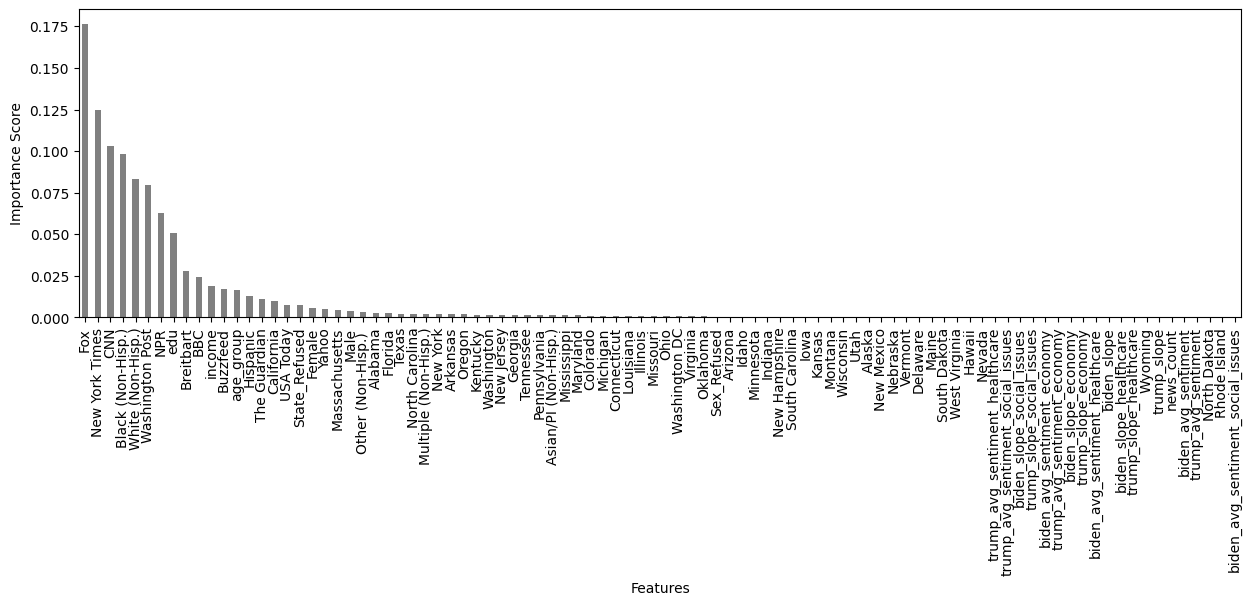

In [15]:
# Recompute feature matrices using the best time window
final_X_train = calculate_features_with_window(X_train, news_sentiment, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)
final_X_val = calculate_features_with_window(X_val, news_sentiment, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources)

# Align columns
final_X_val = final_X_val[final_X_train.columns]

# Extract best hyperparameters
best_params = best_result['best_params']
rf_best = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Fit on best time window's data
rf_best.fit(final_X_train, y_train)

# plot feature importance
feature_importance = pd.Series(rf_best.feature_importances_, index=final_X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(15, 4), color='gray')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [16]:
y_val_pred = rf_best.predict(final_X_val)
val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_report_df = pd.DataFrame(val_report).T
val_report_df

,precision,recall,f1-score,support
1,0.803254,0.731806,0.765867,742.000000
2,0.681600,0.762075,0.719595,559.000000
accuracy,0.744812,0.744812,0.744812,0.744812
macro avg,0.742427,0.746941,0.742731,1301.000000
weighted avg,0.750983,0.744812,0.745985,1301.000000


In [17]:
# Save model
joblib.dump(rf_best, 'models/news_content_model.pkl')

['models/news_content_model.pkl']

In [18]:
# Prepare test features using the best time window and same attributes
final_X_test = calculate_features_with_window(
    X_test, news_sentiment, best_result['time_window'],
    topics=topics, candidate_scores=candidate_scores, sources=sources
)
final_X_test = final_X_test[final_X_train.columns]  # Ensure column order matches training

# 3. Predict and evaluate
y_test_pred = rf_best.predict(final_X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_test_pred)


In [19]:
test_report_df = pd.DataFrame(test_report).T
test_report_df

,precision,recall,f1-score,support
1,0.793205,0.734610,0.762784,731.000000
2,0.689103,0.754386,0.720268,570.000000
accuracy,0.743274,0.743274,0.743274,0.743274
macro avg,0.741154,0.744498,0.741526,1301.000000
weighted avg,0.747595,0.743274,0.744157,1301.000000


In [20]:
# Calculate 95% confidence interval for the test accuracy
n = len(y_test)
z = norm.ppf(0.975)  # 1.96 for 95% confidence
se = np.sqrt((test_accuracy * (1 - test_accuracy)) / n)
margin_of_error = z * se

print(f"Test Accuracy: {test_accuracy:.3f} ± {margin_of_error:.3f} (95% CI)")
print(f"95% CI: [{test_accuracy - margin_of_error:.3f}, {test_accuracy + margin_of_error:.3f}]")

Test Accuracy: 0.743 ± 0.024 (95% CI)
95% CI: [0.720, 0.767]
